In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.feature_selection import RFECV

np.random.seed(42)
import warnings
warnings.filterwarnings(action="ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.max_rows = 20
pd.options.display.max_columns = 10

# Exploratory Data Analysis <a name="eda"></a>

## Preview dataset <a name="preview"></a>

In [12]:
house = pd.read_csv('/content/drive/My Drive/House/train.csv')
house

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,...,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,...,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,...,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,...,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,...,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,...,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,...,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,...,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,...,4,2010,WD,Normal,142125


There are 1460 samples and 79 variables (excluding Id and SalePrice)

In [13]:
house.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

There are 43 categorical features, 36 numerical features (excluding Id and SalePrice)

In [14]:
house['SalePrice'].describe() # summary stats of dependent variable

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

## Create train and test set <a name="create"></a>

In [0]:
# Create test set
x = house.drop(['SalePrice', 'Id'],axis=1)
y = house['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [0]:
# Create training set 
train = pd.concat([x_train, y_train], axis=1) # combine features and SalePrice together

## Check for missing values <a name="check"></a>

In [0]:
def check_na(data):
    total = data.isnull().sum() 
    percent = total/len(data)*100 
    dtype = data.dtypes 

    nans = pd.concat([total, percent, dtype], axis=1, keys=['Total', 'Percent', 'Dtype'])
    nans = nans.sort_values(by = ['Percent'], ascending = False)

    num_missing_variable = data.isnull().any().sum() 
    
    return nans.head(num_missing_variable) 

In [18]:
check_na(train)

,Total,Percent,Dtype
PoolQC,1163,99.571918,object
MiscFeature,1124,96.232877,object
Alley,1097,93.921233,object
Fence,954,81.678082,object
FireplaceQu,548,46.917808,object
LotFrontage,209,17.893836,float64
GarageYrBlt,61,5.222603,float64
GarageCond,61,5.222603,object
GarageType,61,5.222603,object
GarageFinish,61,5.222603,object


The table above shows only the variables with missing values. It shows the number of missing values, percent of missing values, and the data type of the variable

## Scatter plots <a name="scatter"></a>

I created scatter plots to look at the relationship between SalePrice and numerical features. The scatter plots were sorted based on correlation coefficient, in descending order

In [0]:
def plot_scatter(data):
    corr = data.corr() 
    corr_desc = pd.DataFrame(corr['SalePrice'].sort_values(ascending = False))

    corr_desc.drop(['SalePrice'],axis=0, inplace = True) 

    # convert data has to long format for FacetGrid
    long_df = pd.melt(data, id_vars = ['SalePrice'], 
                      value_vars = list(corr_desc.index),  
                      var_name = 'Feature', 
                      value_name = 'Values')

    subplots = sns.FacetGrid(long_df, col="Feature", col_wrap = 6, sharex = False) 
    subplots.map(plt.scatter, "Values", "SalePrice", alpha=0.2)

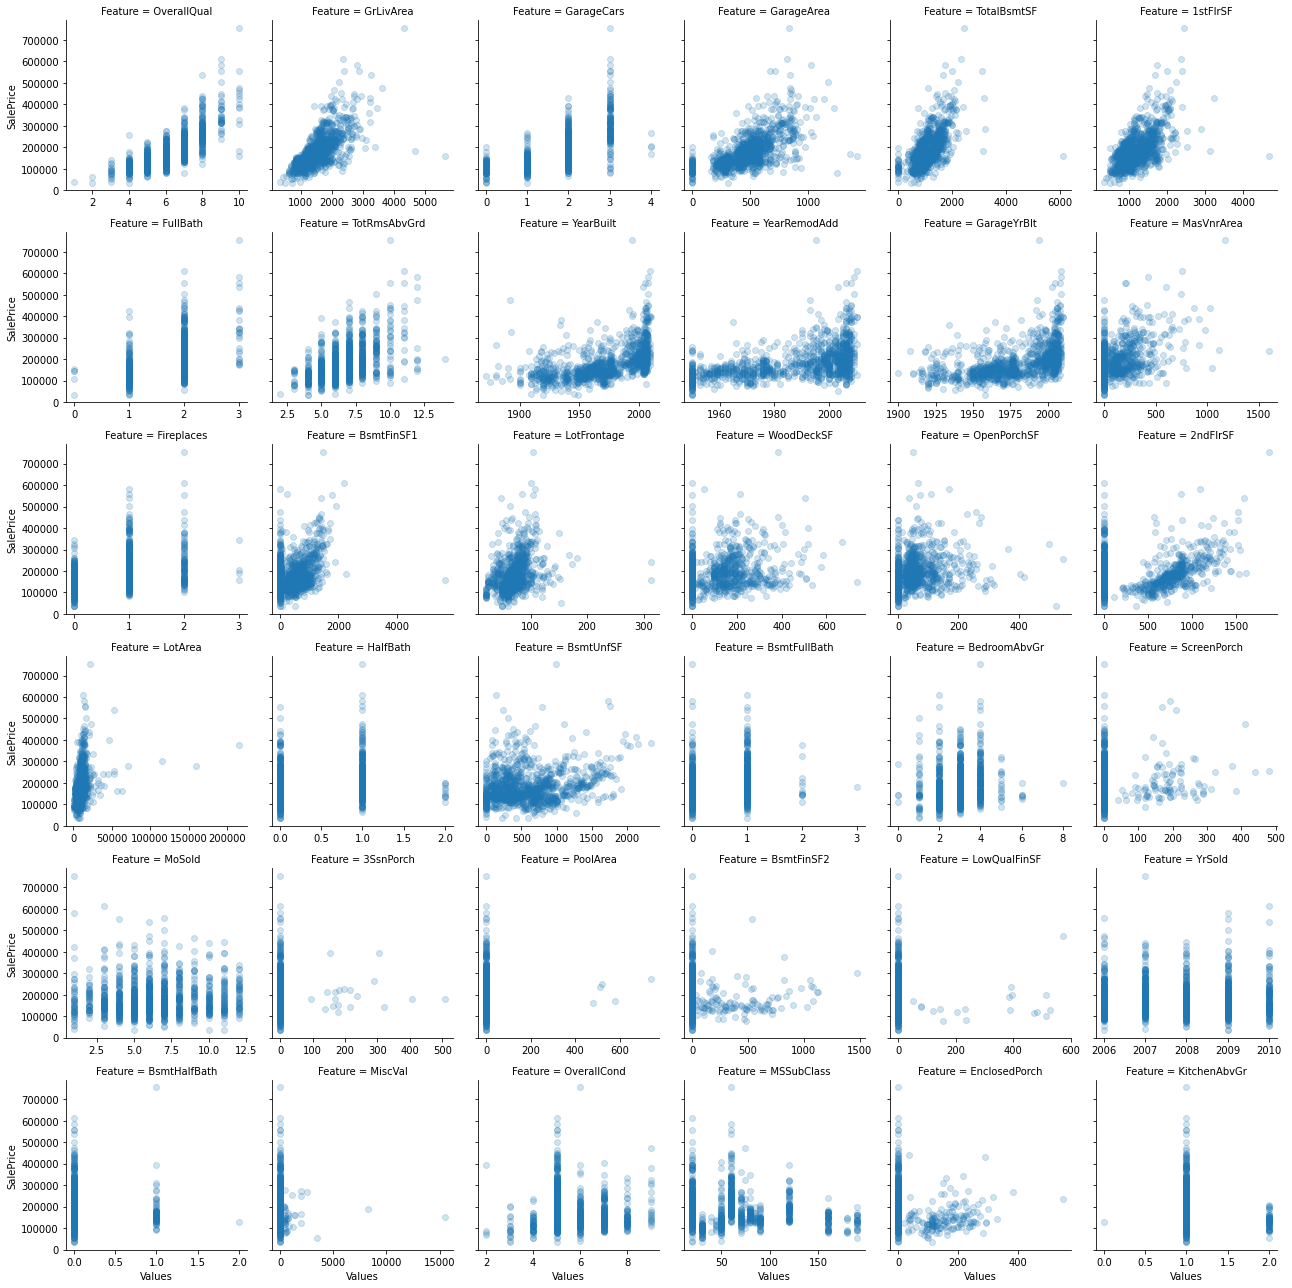

In [20]:
plot_scatter(train)

I will convert MSSubClass and MoSold to categorical features later in the data processing stage. It doesnt make sense for them to be numerical features. <br>
I will also create new features to better represent the information on years (YrSold, YearBuilt, GarageYrBuilt, YearRemodAdd)

## Boxplots <a name="box"></a>

I created boxplots to visualize the categorical features <br>

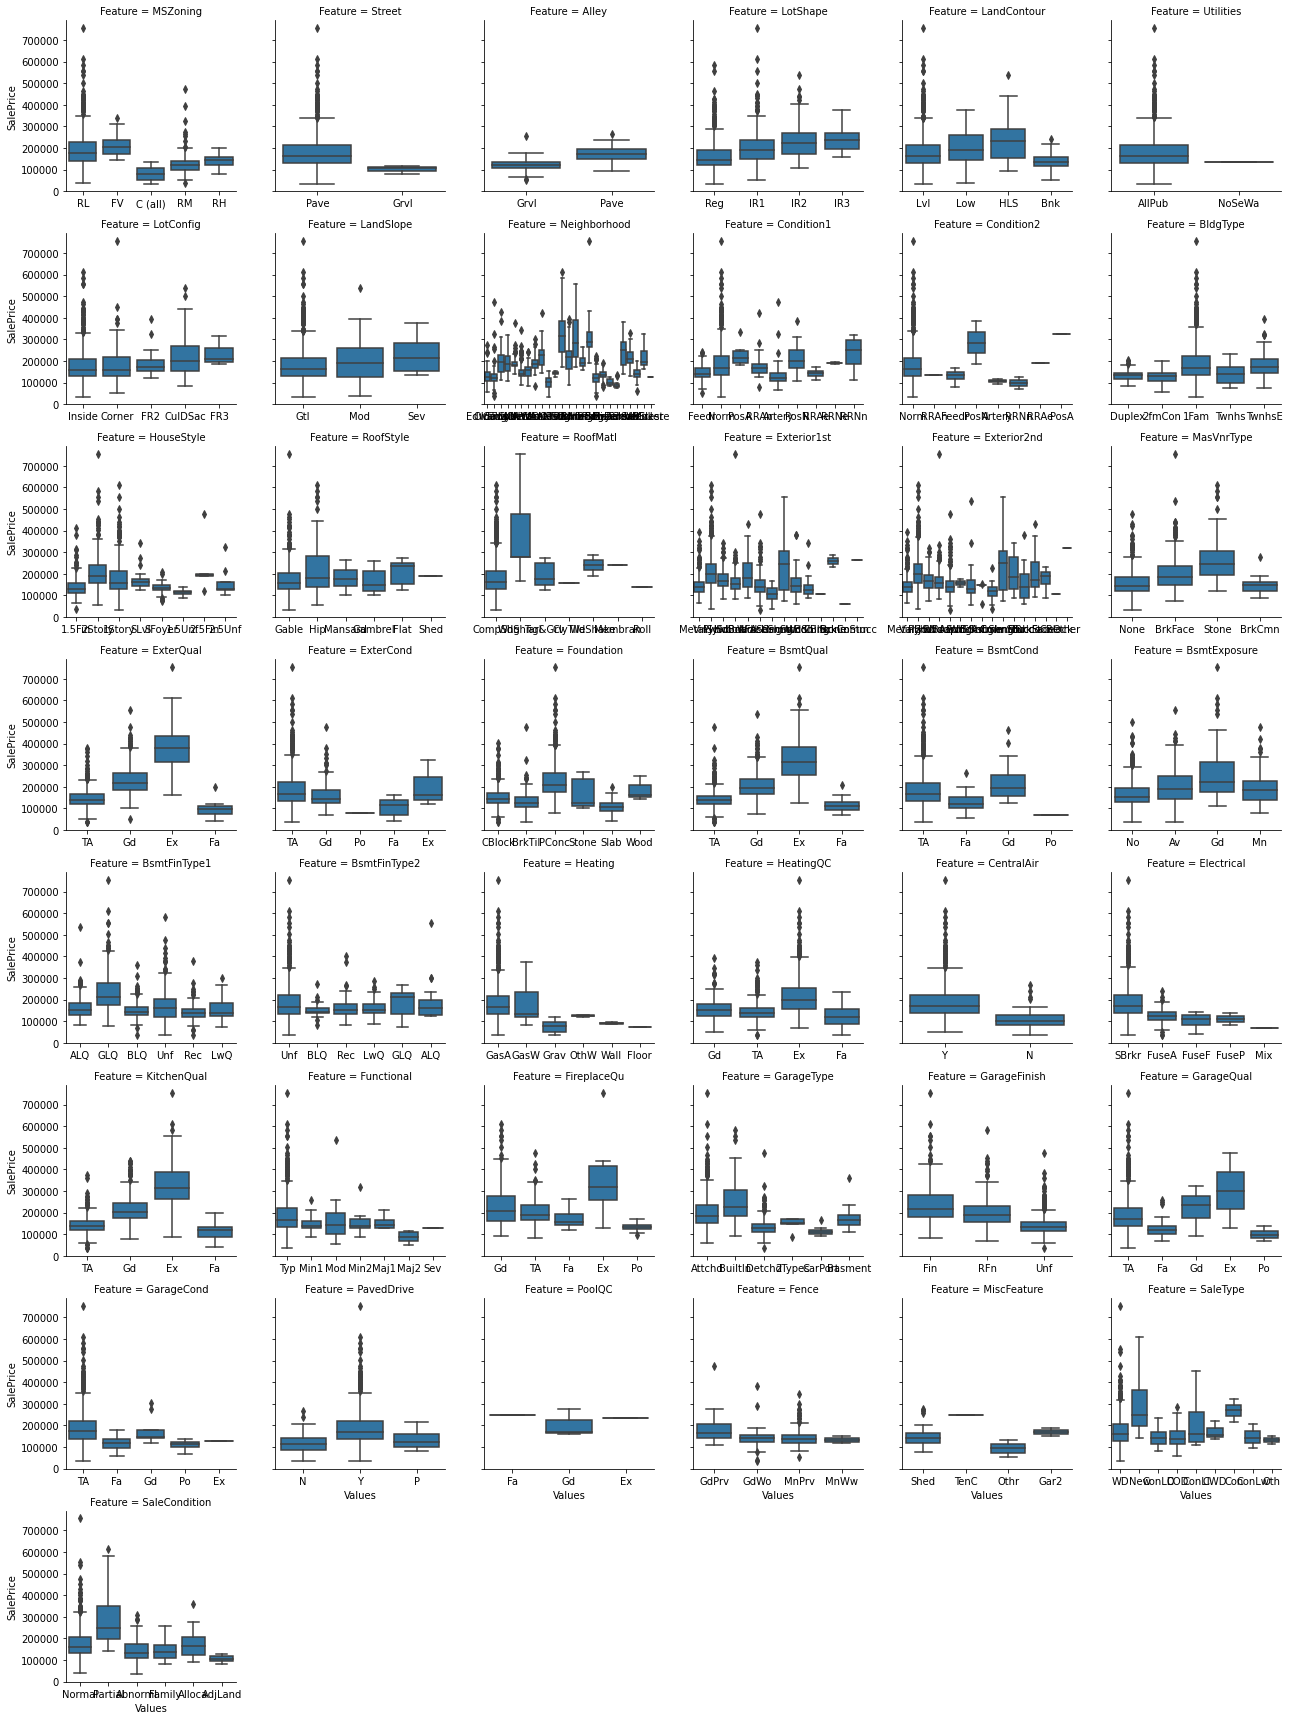

In [21]:
categorical = train.select_dtypes('object') 

long_df = pd.melt(train, id_vars = ['SalePrice'], value_vars = list(categorical),  
                  var_name = 'Feature', value_name = 'Values')

subplots = sns.FacetGrid(long_df, col="Feature", col_wrap = 6, sharex = False) 
subplots.map(sns.boxplot, "Values", "SalePrice")

# 2. Data Processing <a name="dp"></a>

In [0]:
x_train_tr = x_train.copy()

## Create new features <a name="create"></a>

In [0]:
def new_features(X):
    X['AgeBuilt'] = X['YrSold'] - X['YearBuilt'] #age of house since it was built
    X['AgeGarageBlt'] = X['YrSold'] - X['GarageYrBlt'] #age of garage since it was built
    X['AgeRemodeled'] = X['YrSold'] - X['YearRemodAdd'] #age of house since it was remodeled

    drop_var1 = ['YrSold','YearBuilt','GarageYrBlt','YearRemodAdd']
    X.drop(drop_var1, axis=1, inplace = True)
      
    return X

In [0]:
x_train_tr = new_features(x_train_tr)

## Convert numerical to categorical features <a name="conv"></a>

In [0]:
def num_to_cat(X):
    X['MSSubClass'] = X['MSSubClass'].astype(str)
    X['MoSold'] = X['MoSold'].astype(str)
    return X

In [0]:
x_train_tr = num_to_cat(x_train_tr)

## Handle missing values <a name="handle"></a>

Based on the *description.txt* file on Kaggle, some of the categorical features have 'None' as one of the levels, which is abbreviated to NA in the dataset. 

In Python, NA is interepreted as missing values. To fix this discrepancy, I decided to replace the missing values in these categorical features as 'None'.

In [0]:
def nan_to_none(X): 
    
    features_with_none_level = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                                'BsmtFinType2','FireplaceQu','GarageType', 'GarageFinish',
                                'GarageQual','GarageCond','PoolQC','Fence','MiscFeature']
    
    for col_name in features_with_none_level:    
        X[col_name] = X[col_name].fillna('None')
        
    return X

In [0]:
x_train_tr = nan_to_none(x_train_tr)

In [0]:
def handle_missing_values(X): 

    for fill_0 in ['MasVnrArea', 'GarageCars', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 
                    'BsmtFinSF2', 'TotalBsmtSF', 'GarageArea', 'BsmtUnfSF']:
        X[fill_0] = X[fill_0].fillna(0)

    #replace NA in numerical features with median of the corresponding features in training set
    for num_col in list(X.select_dtypes(exclude='object')):
        X[num_col] = X[num_col].fillna(X[num_col].median()) 

    #replace NA in categorical features with mode of the corresponding features in training set
    for categ_col in list(X.select_dtypes(include='object')):
        X[categ_col] = X[categ_col].fillna(X[categ_col].mode()[0]) 
        
    return X

In the *handle_missing_values* function above, there are 3 separate steps:

1. Replace missing values in some of the features to **0**
2. Replace missing values in the remaining numerical features to the respective **median**
3. Replace missing values in the remaining categorical features to the respective **mode**


In [0]:
x_train_tr = handle_missing_values(x_train_tr)

In [63]:
check_na(x_train_tr) 

,Total,Percent,Dtype


There are no more missing values in the training dataset

In [64]:
# Create a dictionary to store the median of numerical features in training set
median_value = {}

for num_col in list(x_train_tr.select_dtypes(exclude='object')):
  median_value[num_col] = x_train_tr[num_col].median()

joblib.dump(median_value, "/content/drive/My Drive/House/median_value.pkl")

['/content/drive/My Drive/House/median_value.pkl']

In [65]:
# Create a dictionary to store the mode of categorical features in training set
mode_value = {}

for categ_col in list(x_train_tr.select_dtypes(include='object')):
  mode_value[categ_col] = x_train_tr[categ_col].mode()[0]

joblib.dump(mode_value, "/content/drive/My Drive/House/mode_value.pkl")

['/content/drive/My Drive/House/mode_value.pkl']

In the 2 cells above, I saved the mode and median values computed from the training set. These values will be used later when handling missing values in the test set or any new datasets

## Ordinal encoding <a name="ordinal"></a>

I encoded some of the categorical features into ordinal features. <br>

For example: The feature 'ExterQual' has 5 levels: Excellent, Good, Average/Typical, Fair, Poor. <br>
I encoded the levels as follows: 0 for Poor, 1 for Fair, 2 for Average/Typical, and so on. <br>

By encoding them into ordinal values, it allows me to plot them as scatter plots and better understand their correlation with SalePrice

In [0]:
x_train_encode = x_train_tr.copy() 

In [0]:
def ordinal_encoding(X):
    X['Functional'] = X['Functional'].map({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0})
    X['Alley'] = X['Alley'].map({'Pave':2,'Grvl':1,'None':0})
    X['Street'] = X['Street'].map({'Pave':1,'Grvl':0})
    X['LotShape'] = X['LotShape'].map({'Reg':3, 'IR1':2,'IR2':1,'IR3':0})
    X['Utilities'] = X['Utilities'].map({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':1}) 
    X['LandSlope'] = X['LandSlope'].map({'Gtl':2,'Mod':1,'Sev':0})
    X['ExterQual'] = X['ExterQual'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})
    X['ExterCond'] = X['ExterCond'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})
    X['BsmtQual'] = X['BsmtQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
    X['BsmtCond'] = X['BsmtCond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
    X['BsmtExposure'] = X['BsmtExposure'].map({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0})
    X['BsmtFinType1'] = X['BsmtFinType1'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0})
    X['BsmtFinType2'] = X['BsmtFinType2'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0})
    X['HeatingQC'] = X['HeatingQC'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})
    X['CentralAir'] = X['CentralAir'].map({'N':0,'Y':1})
    X['KitchenQual'] = X['KitchenQual'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})
    X['FireplaceQu'] = X['FireplaceQu'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
    X['GarageFinish'] = X['GarageFinish'].map({'Fin':3,'RFn':2,'Unf':1,'None':0})
    X['GarageQual'] = X['GarageQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
    X['GarageCond'] = X['GarageCond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
    X['PavedDrive'] = X['PavedDrive'].map({'Y':2,'P':1,'N':0})
    X['PoolQC'] = X['PoolQC'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'None':0})
    
    return X

In [0]:
x_train_encode = ordinal_encoding(x_train_encode)

## Feature scaling <a name="fs"></a>

In [0]:
x_train_scaled = x_train_encode.copy()

In [0]:
# Feature scaling
fs = RobustScaler() 
cols_scaled = list(x_train_scaled.select_dtypes(exclude='object')) #numerical features to be scaled
x_train_scaled[cols_scaled] = fs.fit_transform(x_train_scaled[cols_scaled]) 

In [71]:
joblib.dump(fs, "/content/drive/My Drive/House/robust_scaler.pkl")

['/content/drive/My Drive/House/robust_scaler.pkl']

## Remove unnecessary numerical features <a name="rn"></a>

Plot numerical features against SalePrice

In [0]:
train_tr = pd.concat([x_train_scaled,y_train], axis=1)

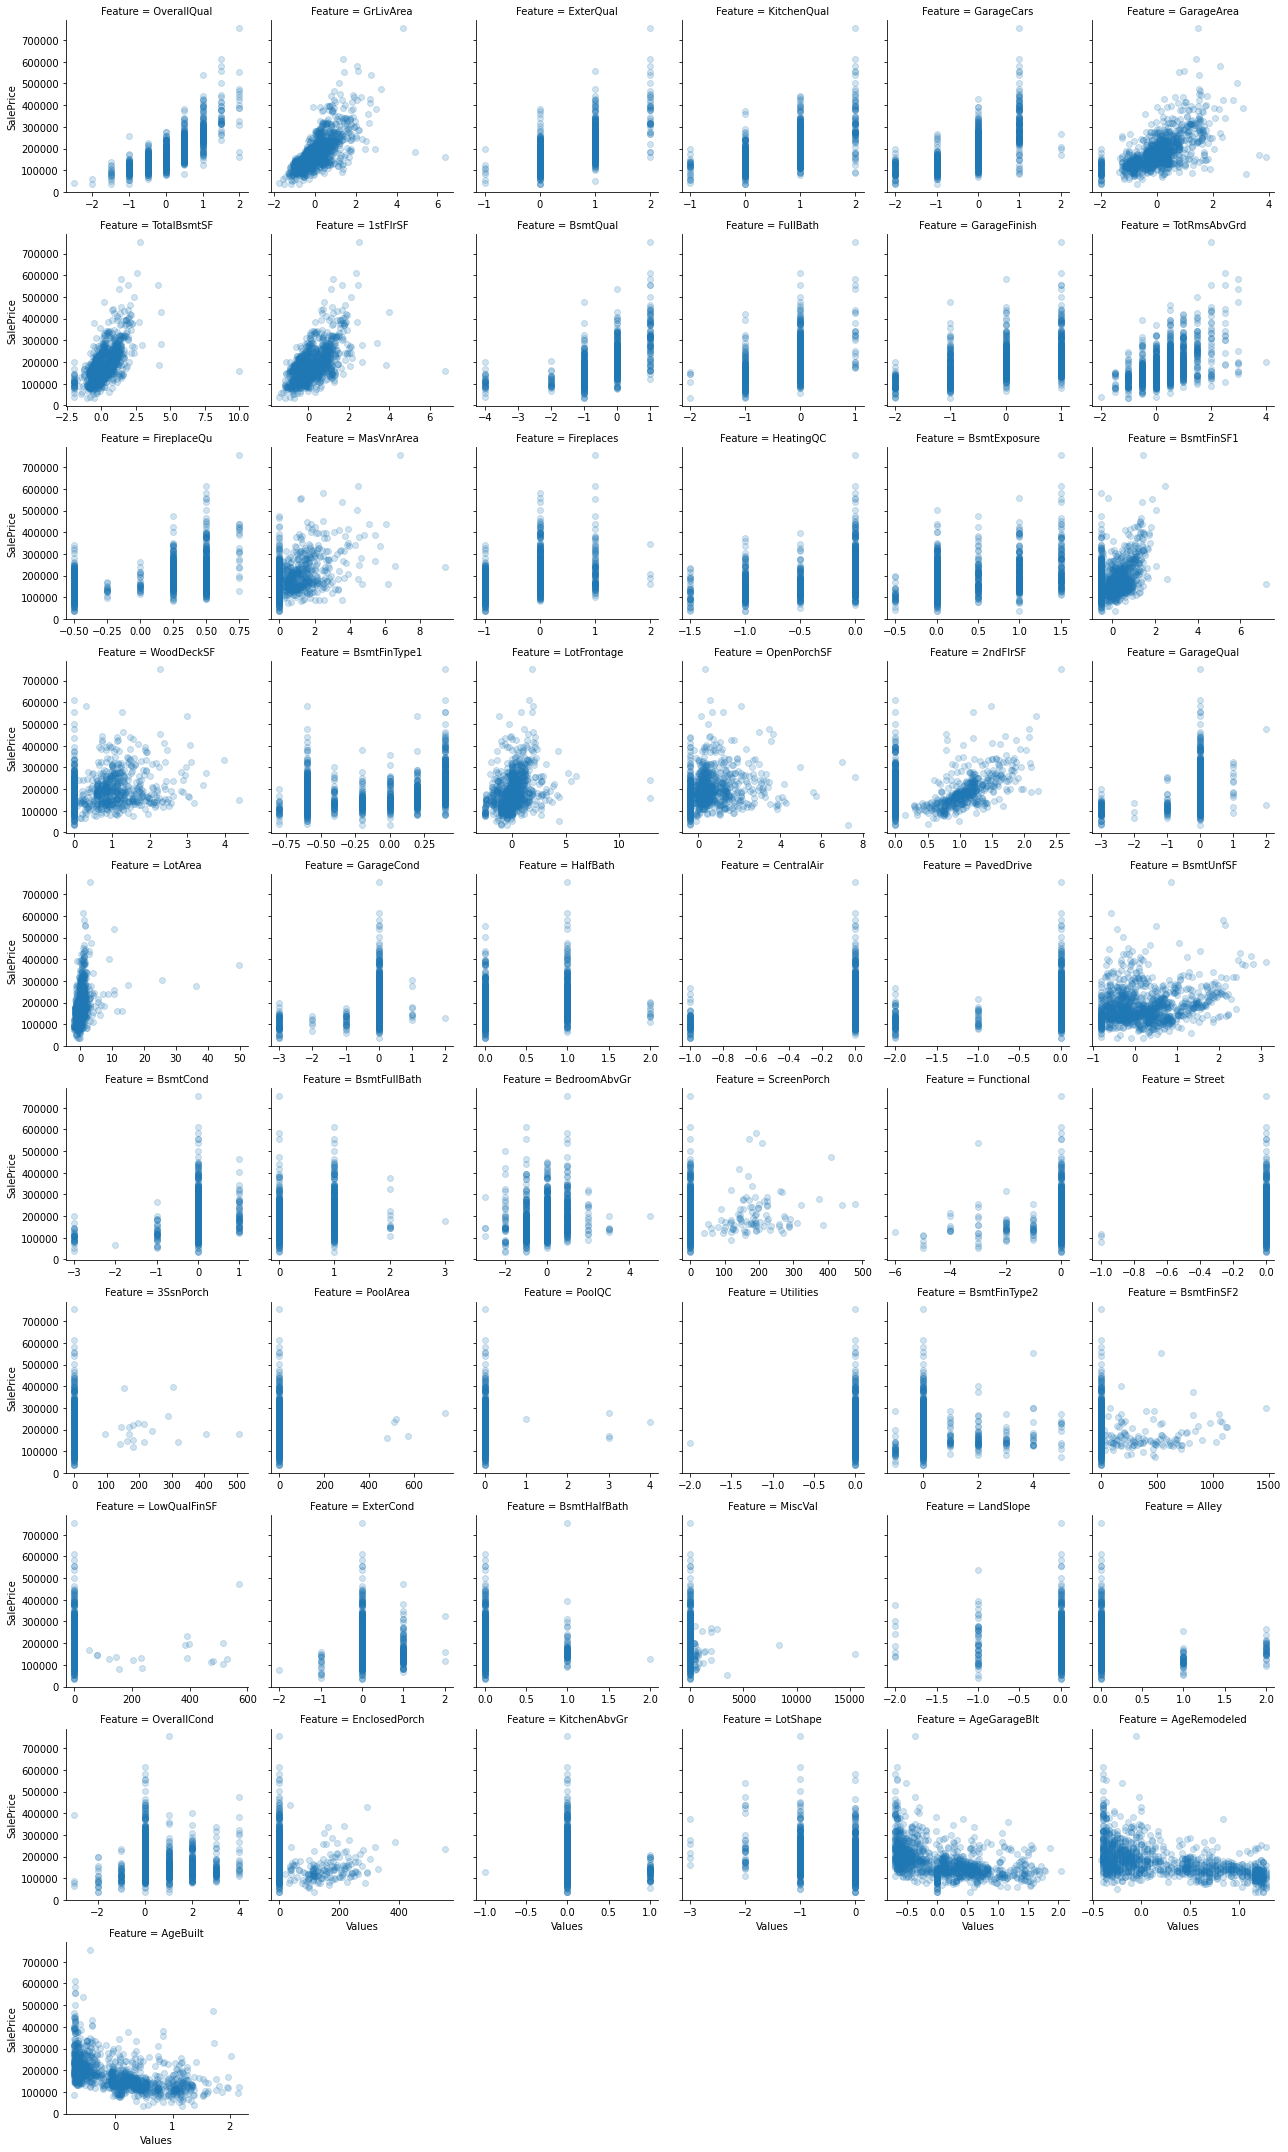

In [73]:
plot_scatter(train_tr) 

In [0]:
drop_var2 = ['Street','3SsnPorch','PoolArea','PoolQC','Utilities','LowQualFinSF']
train_tr.drop (drop_var2, axis=1, inplace=True)

I dropped some of the numerical features that I believe have no clear relationship with SalePrice

I plotted a heatmap to visualize collinearity

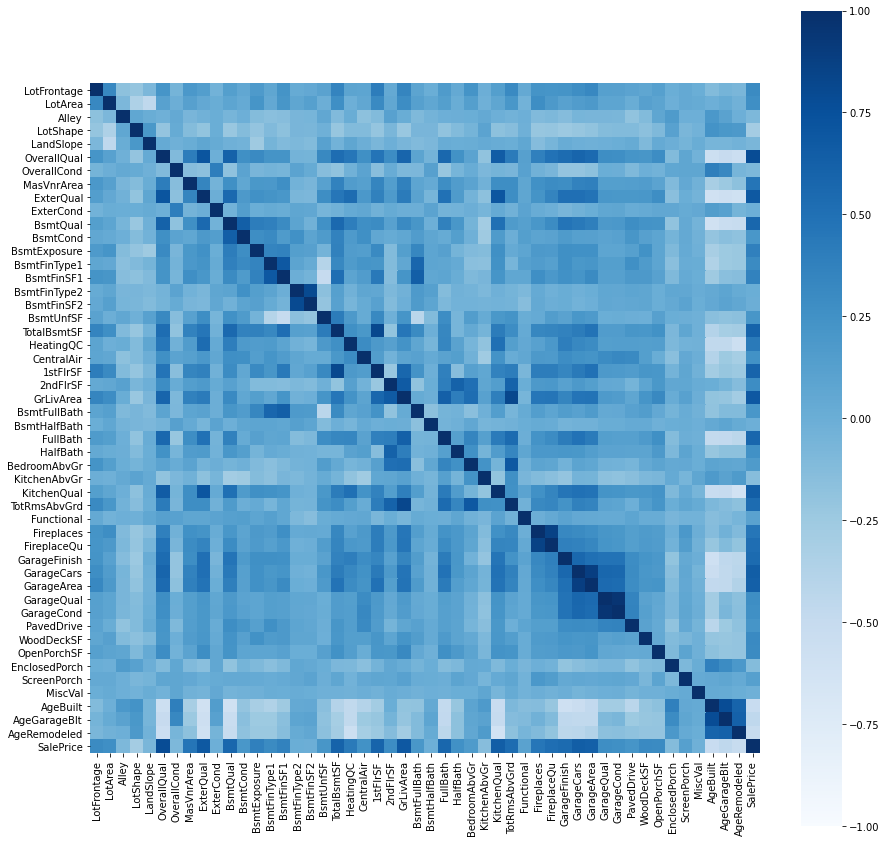

In [79]:
corrmat = train_tr.corr()
plt.figure(figsize=(15,15)) #height, width
sns.heatmap(corrmat, vmin = -1, vmax = 1, cmap = 'Blues', square = True, annot=False, 
            fmt='.2f',annot_kws={'size': 8})

I originally set the vmin=0.8 & vmax=1 for the heatmap above, so that it's easier to find features with high positive correlation. Then, I set the vmin=-0.8 and vmax=-1, so it's easier to detect features with high negative correlation.

Based on the heatmap, it seems like there is high correlation between:
- GarageArea and GarageCars
- TotalBsmtSF and BsmtQual
- GrLivArea and TotRmsAbvGrd
- KitchenQual and ExterQual
- AgeGarageBlt and AgeBuilt
- AgeRemodeled and AgeGarageBlt
- AgeBuilt and AgeRemodeled

For each pair, I will drop the feature that has a lower correlation with SalePrice

In [0]:
drop_var3 = ['GarageCars','BsmtQual','TotRmsAbvGrd','KitchenQual','AgeGarageBlt','AgeRemodeled']
train_tr.drop (drop_var3, axis=1, inplace=True)

## Remove unnecessary categorical features <a name="rc"></a>

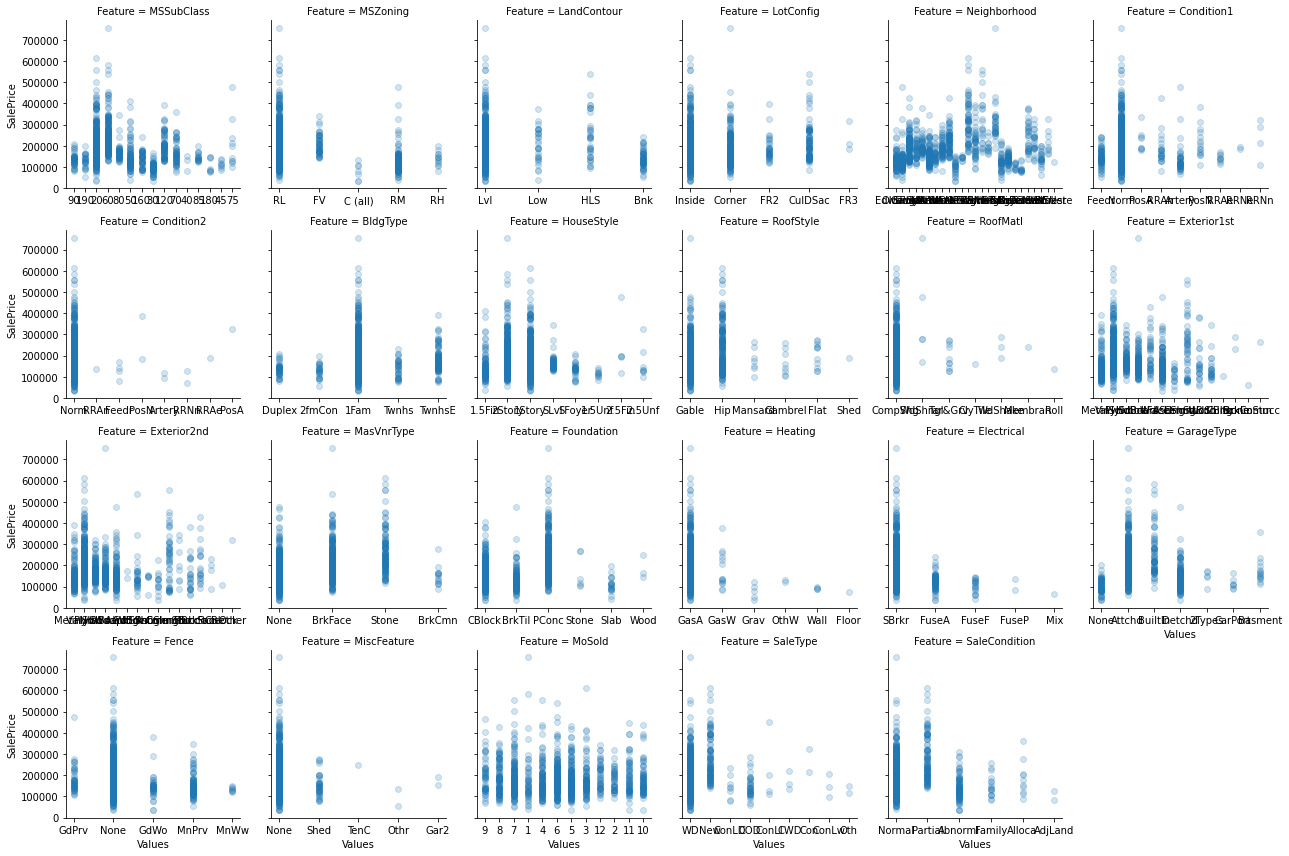

In [81]:
categorical = train_tr.select_dtypes('object') 

long_df = pd.melt(train_tr, id_vars = ['SalePrice'], value_vars = list(categorical),  #Note: corr_asc.index gets the NAMES of numerical features correlated with SalePrice (high to low correlation value)
                  var_name = 'Feature', value_name = 'Values')

subplots = sns.FacetGrid(long_df, col="Feature", col_wrap = 6, sharex = False) # sharex=True means all x-axis have same scale
subplots.map(plt.scatter, "Values", "SalePrice", alpha = 0.2)

In [0]:
drop_var4 = ['Condition2', 'RoofMatl', 'Heating','MiscFeature']
train_tr.drop (drop_var4, axis=1, inplace=True)

I removed the above categorical features because majority of the observations are only in one level

## Dummy coding <a name="dummy"></a>

In [0]:
train_tr = pd.get_dummies(train_tr)

# Train Models <a name="train"></a>

In [0]:
X = train_tr.drop('SalePrice',axis=1) 
y = train_tr['SalePrice']

In [0]:
#joblib.dump(X.columns,'/content/drive/My Drive/House/train_features.pkl') # save feature names
joblib.dump(X,'/content/drive/My Drive/House/X_train.pkl' ) # save processed training features
joblib.dump(y,'/content/drive/My Drive/House/y_train.pkl' ) # save training SalePrice

In [0]:
def train_error(model, X, y):
    y_pred = model.predict(X)
    rmsle = np.sqrt (mean_squared_log_error(y, y_pred))
    print (f"Train RMSLE: {rmsle:.4f}")  

In [0]:
def cv_error(model, X, y): 
    scores = cross_val_score(model, X, y, scoring = "neg_mean_squared_log_error", cv = 5) 
    rmsle = np.sqrt(-scores) 
    print (f"Mean CV RMSLE: {rmsle.mean():.4f} ± {rmsle.std():.4f}")  

## Random Forest <a name="forest"></a>

In [152]:
forest = RandomForestRegressor(random_state=42, n_estimators = 1000, max_features = 0.3)
forest.fit(X, y)
train_error(forest, X, y)
cv_error(forest, X, y)

Train RMSLE: 0.0573
Mean CV RMSLE: 0.1428 ± 0.0213


## XGBoost <a name="xg"></a>

In [153]:
xg = xgboost.XGBRegressor(random_state=42, silent = True, n_estimators = 1000)
xg.fit(X, y)
train_error (xg, X, y)
cv_error(xg,X, y)

Train RMSLE: 0.0230
Mean CV RMSLE: 0.1270 ± 0.0141


XGBoost produced a lower training error and cross-validation error than Random Forest, but there is high variance. To reduce variance and improve XGBoost performance, I decided to identify optimal hyperparameters using grid search (*n_estimators, learning_rate, max_depth*) 

## Fine-tune model <a name="tune"></a>

In [133]:
# GridSearchCV 
param_grid = [
    {'n_estimators': [100, 500, 1000, 1500], 
     'learning_rate' :[0.1, 0.01], 
     'max_depth': [1,2] 
    } 
]

xg = xgboost.XGBRegressor(random_state=42, silent=True) # define a new xgboost model

grid_search = GridSearchCV(xg, param_grid, cv = 5, scoring = "neg_mean_squared_log_error") 
grid_search.fit(X, y)

joblib.dump(grid_search,"/content/drive/My Drive/House/grid_search.pkl") # save grid search

grid_search.best_params_ # best hyperparameters

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000}

In [146]:
# Train a new XGBoost using the new parameters
xg_tuned = xgboost.XGBRegressor(learning_rate= 0.1, max_depth= 2, n_estimators= 1000,
                                random_state=42, silent=True)
xg_tuned.fit(X, y)

joblib.dump(xg_tuned, "/content/drive/My Drive/House/xg_tuned.pkl" ) # save model

train_error (xg_tuned, X, y)
cv_error(xg_tuned, X, y)

Train RMSLE: 0.0537
Mean CV RMSLE: 0.1265 ± 0.0163


After fine-tuning some of the hyperparameters, variance was reduced but there is still some overfitting. I decided to reduce the number of features to further reduce the complexity of the model and reduce variance. I used recursive feature elimination with cross-validation (RFECV).

In [159]:
rfecv = RFECV(xg_tuned, cv = 5, scoring = "neg_mean_squared_log_error")
rfecv.fit(X, y)

joblib.dump(rfecv,'/content/drive/My Drive/House/rfecv.pkl' ) # save RFECV

print (f"Number of selected features: {rfecv.n_features_}")

Number of selected features: 122


In [160]:
train_features = X.columns[rfecv.support_] # names of the selected features from RFECV
joblib.dump(train_features,"/content/drive/My Drive/House/train_features.pkl") # save feature names

['/content/drive/My Drive/House/train_features.pkl']

In [161]:
X_rfecv = X[train_features] # reduced feature dataset
joblib.dump(X_rfecv,'/content/drive/My Drive/House/X_train_rfecv.pkl' ) 

['/content/drive/My Drive/House/X_train_rfecv.pkl']

In [164]:
# Train
xg_tuned.fit(X_rfecv,y) #train the previously tuned XGBoost using the features selected by RFECV

joblib.dump(xg_tuned, "/content/drive/My Drive/House/xg_rfecv.pkl") #save model

train_error (xg_tuned, X_rfecv, y)
cv_error(xg_tuned, X_rfecv, y)

Train RMSLE: 0.0539
Mean CV RMSLE: 0.1243 ± 0.0143


After training the XGBoost using the features selected by RFECV, the variance is reduced, but only slightly.  There is still high variance. In the future, I could increase the size of training set, simplify the model by further reducing features, and/or try different techniques during data processing, especially when handling missing values.

# Evaluate on Test Set <a name="test"></a>

In [0]:
!cp "/content/drive/My Drive/House/data_processing.py" .
import data_processing as dp 

I created the **data_processing** module, which consists of methods for processing new datasets. The *full_transform* method in the module includes all of the data processing functions found in this notebook.

In [0]:
X_test = x_test.copy()
X_test = dp.full_transform(X_test) 

In [0]:
def eval_test (model, X, y):
    y_pred = model.predict(X)

    msle = mean_squared_log_error(y, y_pred)
    rmsle = np.sqrt(msle)
    print (f"RMSLE: {rmsle:.4f}")

In [170]:
model = joblib.load("/content/drive/My Drive/House/xg_rfecv.pkl")
eval_test (model, X_test, y_test)

RMSLE: 0.1233


# Evaluate on Submission Set <a name="submit"></a>

In [171]:
submit = pd.read_csv('/content/drive/My Drive/House/test.csv')
submit_id = submit['Id']  # will be needed when writing to file at the end
submit = submit.drop(['Id'],axis=1)
submit = dp.full_transform(submit) # transform the dataset

model = joblib.load("/content/drive/My Drive/House/xg_rfecv.pkl")

y = model.predict(submit) # make predictions

[19:50:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
# Create dataframe and write to file
submit_file = pd.DataFrame({'Id': submit_id, 'SalePrice': y})
submit_file.to_csv('/content/drive/My Drive/House/house_pred_7.csv', index=False)

# References and Acknowledgements <a name="ref"></a>

I learnt some great coding techniques and concepts from the works of Aurelien Geron (author of Hands-On Machine Learning with Scikit-learn and Tensorflow), Lavanya Shukla (https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition), and Pedro Marcelino (https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)